# Delay Line Analysis: Time Domain and Frequency Domain

This notebook demonstrates delay line behavior in both simulation domains:

1. **Time Domain**: Use `DelayLine` to simulate a pulse, then apply FFT to analyze phase shift vs frequency
2. **Frequency Domain**: Use `ConstantTimeDelayVCVS` (TDVCVS = Time-Delay Voltage-Controlled Voltage Source) to compute transfer function, then apply iFFT to reconstruct pulse response

Key insight: A pure delay in time domain corresponds to a linear phase shift in frequency domain:
$$H(\omega) = e^{-j\omega\tau}$$
where $\tau$ is the delay time.

In [ ]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt

from pyvibrate.timedomain import Network as TDNetwork, R, VSource, DelayLine
from pyvibrate.frequencydomain import Network as FDNetwork, R as FD_R, ACSource, ConstantTimeDelayVCVS

## Part 1: Time-Domain Delay Line with FFT Analysis

We'll simulate a pulse passing through a delay line, then use FFT to extract the phase response.

In [4]:
# Simulation parameters
dt = 1e-6          # 1 us timestep
delay_samples = 10 # 10 samples = 10 us delay
tau = delay_samples * dt  # Physical delay time
n_steps = 256      # Total simulation steps (power of 2 for FFT)

print(f"Time step: {dt*1e6:.1f} us")
print(f"Delay: {delay_samples} samples = {tau*1e6:.1f} us")
print(f"Total simulation: {n_steps * dt * 1e6:.0f} us")

Time step: 1.0 us
Delay: 10 samples = 10.0 us
Total simulation: 256 us


In [5]:
# Build time-domain circuit: VSource -> DelayLine -> R_load
net = TDNetwork()
net, v_in = net.node("v_in")
net, v_out = net.node("v_out")

net, vs = VSource(net, v_in, net.gnd, name="vs")
net, dly = DelayLine(net, v_in, net.gnd, v_out, net.gnd, delay_samples=delay_samples, name="dly")
net, r_load = R(net, v_out, net.gnd, name="R_load")

sim = net.compile(dt=dt)
params = {"vs": 0.0, "R_load": 1000.0}
state = sim.init(params)

In [6]:
# Create input pulse: short rectangular pulse at the start
pulse_width = 8  # samples
input_signal = np.zeros(n_steps)
input_signal[2:2+pulse_width] = 1.0  # Pulse from sample 2 to 9

# Simulate and record output
output_signal = np.zeros(n_steps)

for i in range(n_steps):
    controls = {"vs": float(input_signal[i])}
    state = sim.step(params, state, controls)
    output_signal[i] = float(sim.v(state, v_out))

# Time axis
t = np.arange(n_steps) * dt * 1e6  # in microseconds

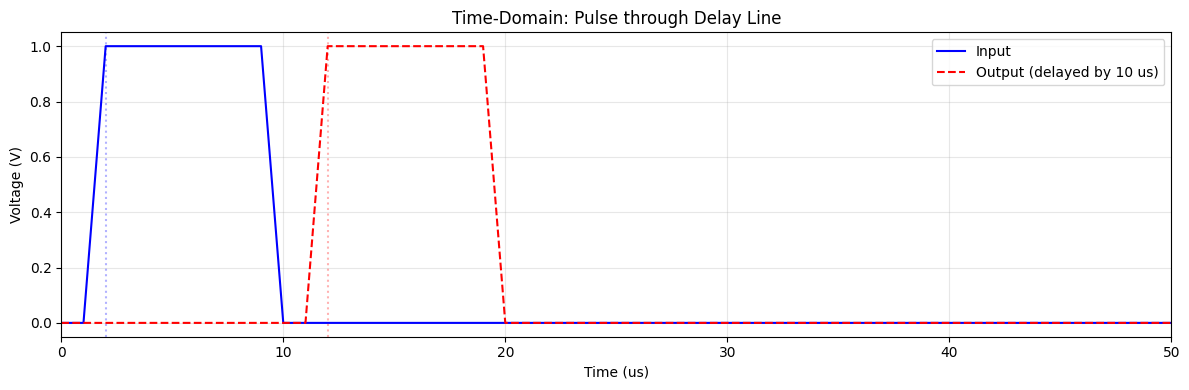

In [7]:
# Plot time-domain signals
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t, input_signal, 'b-', label='Input', linewidth=1.5)
ax.plot(t, output_signal, 'r--', label=f'Output (delayed by {tau*1e6:.0f} us)', linewidth=1.5)

ax.axvline(2 * dt * 1e6, color='b', alpha=0.3, linestyle=':')
ax.axvline((2 + delay_samples) * dt * 1e6, color='r', alpha=0.3, linestyle=':')

ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Time-Domain: Pulse through Delay Line')
ax.set_xlim(0, 50)  # Show first 50 us
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# FFT Analysis: Extract phase shift from time-domain data
# Apply FFT to both input and output
fft_in = np.fft.fft(input_signal)
fft_out = np.fft.fft(output_signal)

# Frequency axis
freqs = np.fft.fftfreq(n_steps, d=dt)
positive_freqs = freqs[:n_steps//2]

# Transfer function H(f) = FFT(output) / FFT(input)
# Avoid division by small numbers
eps = 1e-10
H = fft_out / (fft_in + eps)

# Extract magnitude and phase
H_mag = np.abs(H[:n_steps//2])
H_phase = np.angle(H[:n_steps//2])  # in radians

# Unwrap phase for cleaner plot
H_phase_unwrapped = np.unwrap(H_phase)

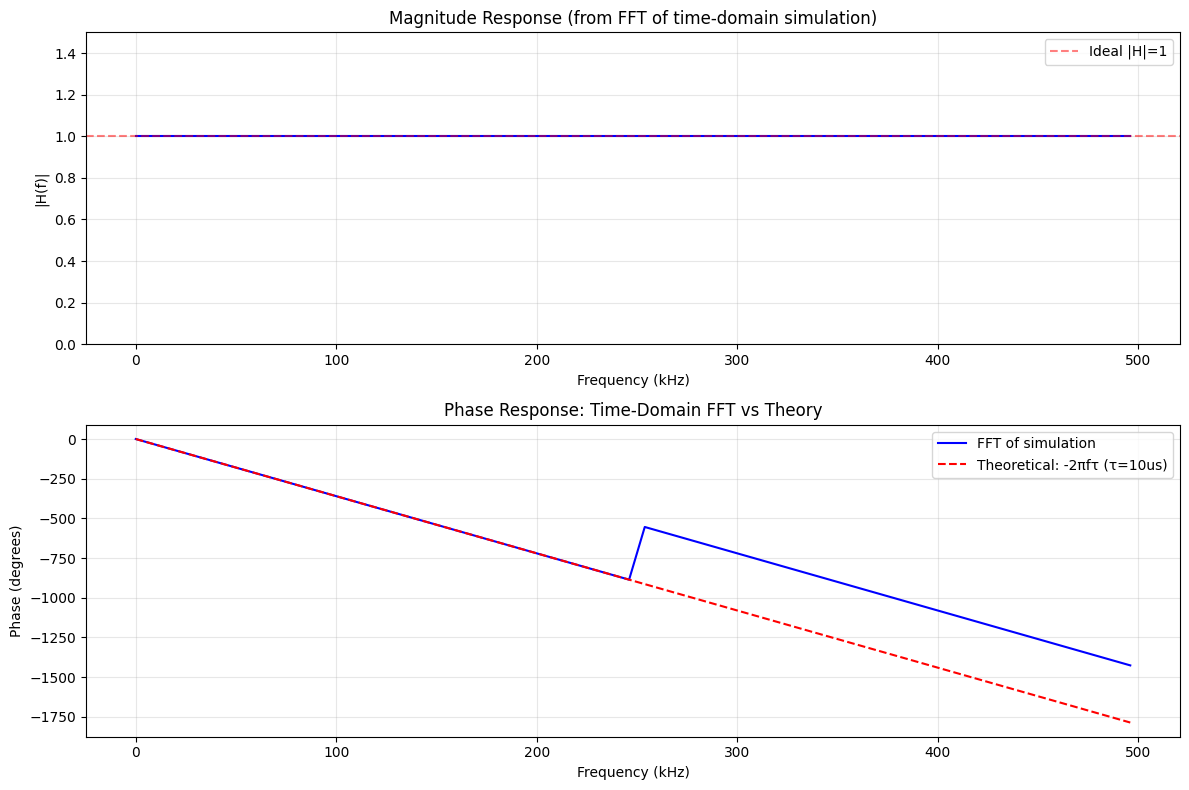


Measured group delay (from FFT): 10.0 us
Expected delay: 10.0 us


In [9]:
# Theoretical phase for pure delay: phase = -omega * tau = -2*pi*f*tau
theoretical_phase = -2 * np.pi * positive_freqs * tau

# Plot FFT results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude response
valid_idx = H_mag > 0.1  # Only show where input has significant energy
ax1.plot(positive_freqs[valid_idx] / 1e3, H_mag[valid_idx], 'b-', linewidth=1.5)
ax1.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Ideal |H|=1')
ax1.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('|H(f)|')
ax1.set_title('Magnitude Response (from FFT of time-domain simulation)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.5)

# Phase response
ax2.plot(positive_freqs[valid_idx] / 1e3, np.degrees(H_phase_unwrapped[valid_idx]), 
         'b-', linewidth=1.5, label='FFT of simulation')
ax2.plot(positive_freqs / 1e3, np.degrees(theoretical_phase), 
         'r--', linewidth=1.5, label=f'Theoretical: -2πfτ (τ={tau*1e6:.0f}us)')
ax2.set_xlabel('Frequency (kHz)')
ax2.set_ylabel('Phase (degrees)')
ax2.set_title('Phase Response: Time-Domain FFT vs Theory')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute group delay from phase slope
df = positive_freqs[1] - positive_freqs[0]
group_delay = -np.diff(H_phase_unwrapped) / (2 * np.pi * df)
print(f"\nMeasured group delay (from FFT): {np.median(group_delay[valid_idx[:-1]])*1e6:.1f} us")
print(f"Expected delay: {tau*1e6:.1f} us")

## Part 2: Frequency-Domain ConstantTimeDelayVCVS with iFFT Pulse Response

Now we'll use the frequency-domain simulator to compute the transfer function directly,
then use inverse FFT to reconstruct the impulse response.

Note: ConstantTimeDelayVCVS (TDVCVS) is an active element with infinite input impedance and zero output impedance.

In [ ]:
# Build frequency-domain circuit: ACSource -> ConstantTimeDelayVCVS -> R_load
# Note: ConstantTimeDelayVCVS is a 4-terminal device (in+, in-, out+, out-)

fd_net = FDNetwork()
fd_net, n_in = fd_net.node("n_in")
fd_net, n_out = fd_net.node("n_out")

# Source with internal resistance
fd_net, vs = ACSource(fd_net, n_in, fd_net.gnd, name="vs", value=1.0)
fd_net, ps = ConstantTimeDelayVCVS(fd_net, n_in, fd_net.gnd, n_out, fd_net.gnd, name="PS", tau=tau)
fd_net, r_load = FD_R(fd_net, n_out, fd_net.gnd, name="R_load", value=1000.0)

solver = fd_net.compile()

print(f"Frequency-domain circuit built with τ = {tau*1e6:.0f} us")

In [11]:
# Sweep frequency and compute transfer function H(f) = V_out / V_in
# Use same frequency points as FFT for comparison
n_freq = n_steps // 2
sweep_freqs = np.linspace(1e3, 400e3, n_freq)  # 1 kHz to 400 kHz

H_fd_mag = np.zeros(n_freq)
H_fd_phase = np.zeros(n_freq)

for i, f in enumerate(sweep_freqs):
    omega = 2 * np.pi * f
    sol = solver.solve_at(omega)
    
    # Get complex voltages
    v_in_complex = solver.v(sol, n_in)
    v_out_complex = solver.v(sol, n_out)
    
    # Transfer function
    H = v_out_complex / v_in_complex
    H_fd_mag[i] = np.abs(H)
    H_fd_phase[i] = np.angle(H)

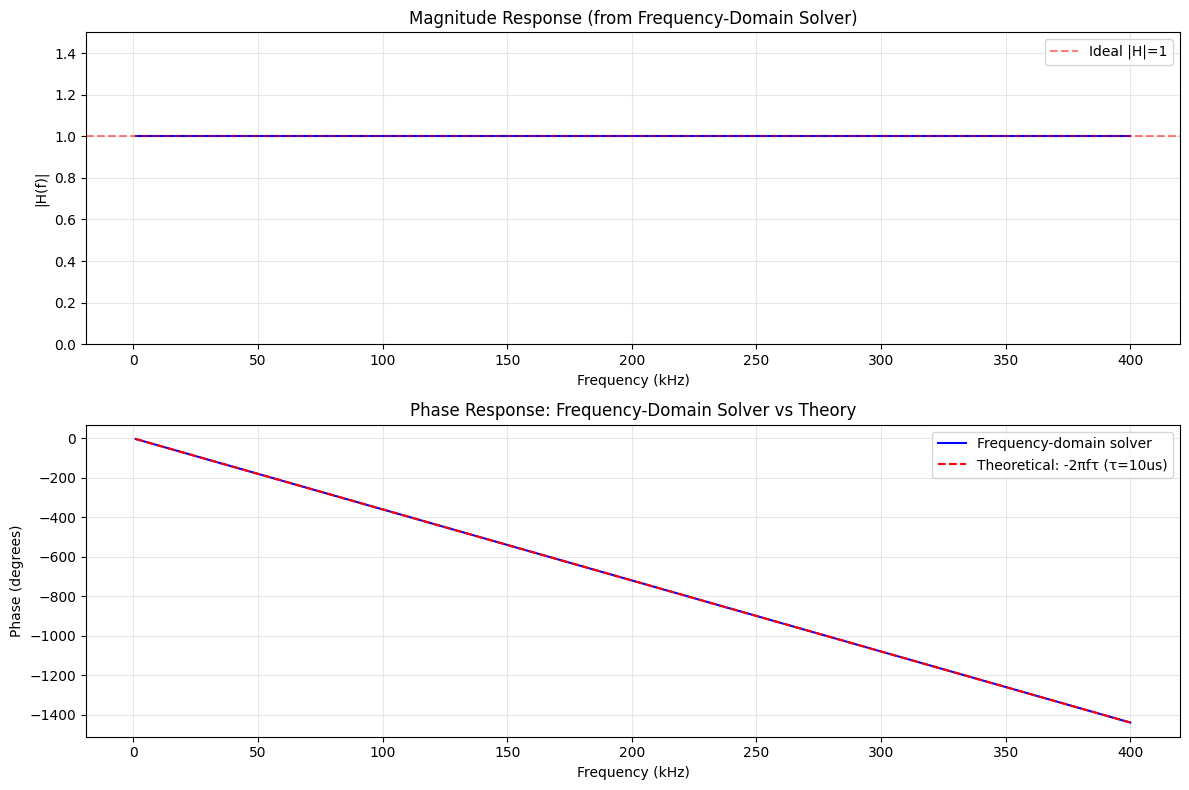

In [12]:
# Theoretical phase for pure delay
theoretical_phase_fd = -2 * np.pi * sweep_freqs * tau

# Plot frequency-domain results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Magnitude
ax1.plot(sweep_freqs / 1e3, H_fd_mag, 'b-', linewidth=1.5)
ax1.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Ideal |H|=1')
ax1.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('|H(f)|')
ax1.set_title('Magnitude Response (from Frequency-Domain Solver)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.5)

# Phase (unwrapped)
H_fd_phase_unwrapped = np.unwrap(H_fd_phase)
ax2.plot(sweep_freqs / 1e3, np.degrees(H_fd_phase_unwrapped), 
         'b-', linewidth=1.5, label='Frequency-domain solver')
ax2.plot(sweep_freqs / 1e3, np.degrees(theoretical_phase_fd), 
         'r--', linewidth=1.5, label=f'Theoretical: -2πfτ (τ={tau*1e6:.0f}us)')
ax2.set_xlabel('Frequency (kHz)')
ax2.set_ylabel('Phase (degrees)')
ax2.set_title('Phase Response: Frequency-Domain Solver vs Theory')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# iFFT: Reconstruct impulse response from frequency-domain transfer function
# Build full spectrum (positive and negative frequencies)

# Sample the transfer function at uniform frequency spacing
n_ifft = 512
f_sample = 1 / dt  # Sampling frequency
ifft_freqs = np.fft.fftfreq(n_ifft, d=dt)

# Compute H(f) = exp(-j*2*pi*f*tau) at these frequencies
# This is the ideal delay transfer function
H_full = np.exp(-1j * 2 * np.pi * ifft_freqs * tau)

# iFFT to get impulse response
impulse_response = np.fft.ifft(H_full).real

# Time axis for impulse response
t_ifft = np.arange(n_ifft) * dt * 1e6  # in microseconds

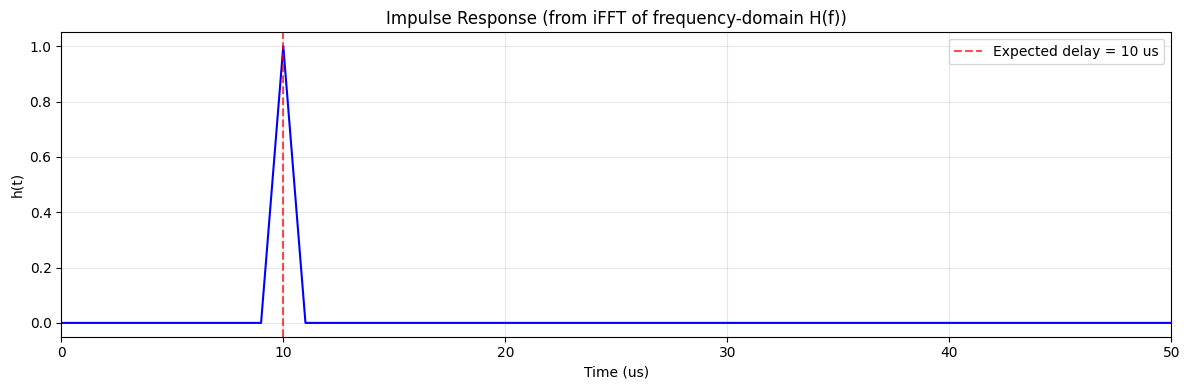

Impulse response peak at: 10.0 us
Expected delay: 10.0 us


In [14]:
# Plot impulse response
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(t_ifft, impulse_response, 'b-', linewidth=1.5)
ax.axvline(tau * 1e6, color='r', linestyle='--', alpha=0.7, label=f'Expected delay = {tau*1e6:.0f} us')

ax.set_xlabel('Time (us)')
ax.set_ylabel('h(t)')
ax.set_title('Impulse Response (from iFFT of frequency-domain H(f))')
ax.set_xlim(0, 50)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find peak position
peak_idx = np.argmax(impulse_response[:n_ifft//2])
print(f"Impulse response peak at: {t_ifft[peak_idx]:.1f} us")
print(f"Expected delay: {tau*1e6:.1f} us")

In [15]:
# Reconstruct pulse response by convolving impulse response with input pulse
# Or equivalently: iFFT(H(f) * FFT(input))

# Pad input signal to match iFFT size
input_padded = np.zeros(n_ifft)
input_padded[:len(input_signal)] = input_signal

# Compute output in frequency domain
fft_input = np.fft.fft(input_padded)
fft_output_fd = H_full * fft_input

# iFFT to get time-domain output
output_from_ifft = np.fft.ifft(fft_output_fd).real

# Time axis
t_padded = np.arange(n_ifft) * dt * 1e6

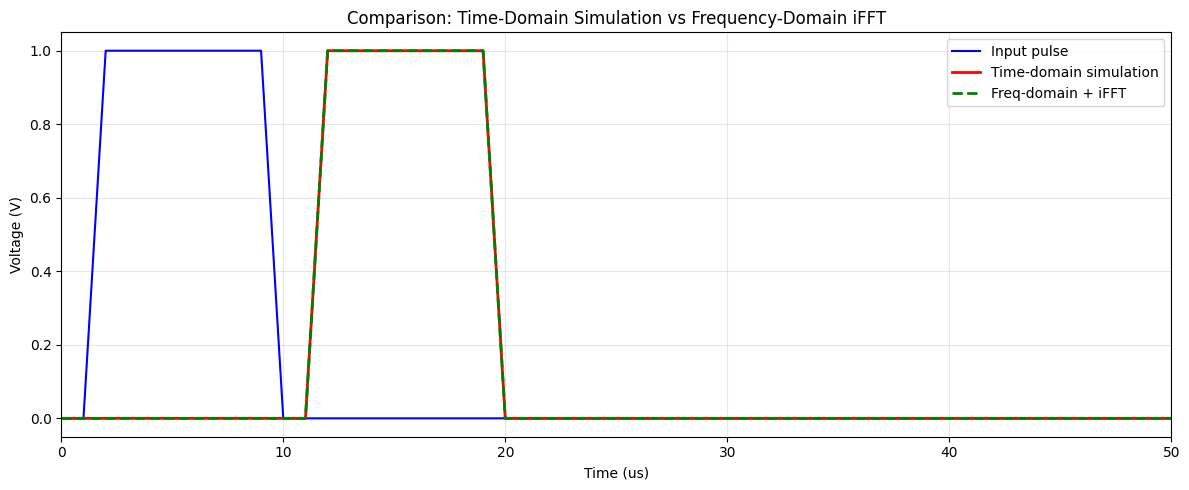

Max difference between methods: 0.0000 V


In [16]:
# Compare: Time-domain simulation vs Frequency-domain + iFFT
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(t, input_signal, 'b-', linewidth=1.5, label='Input pulse')
ax.plot(t, output_signal, 'r-', linewidth=2, label='Time-domain simulation')
ax.plot(t_padded[:len(t)], output_from_ifft[:len(t)], 'g--', linewidth=2, 
        label='Freq-domain + iFFT')

ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Comparison: Time-Domain Simulation vs Frequency-Domain iFFT')
ax.set_xlim(0, 50)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute error
error = np.max(np.abs(output_signal - output_from_ifft[:len(output_signal)]))
print(f"Max difference between methods: {error:.4f} V")

## Summary

This notebook demonstrated the equivalence between time-domain and frequency-domain analysis:

1. **Time Domain → Frequency Domain (FFT)**:
   - Simulated a pulse through `DelayLine` in time domain
   - Applied FFT to extract the transfer function H(f)
   - Verified the phase response matches the theoretical -2πfτ

2. **Frequency Domain → Time Domain (iFFT)**:
   - Used `ConstantTimeDelayVCVS` component to compute H(f) directly
   - Applied iFFT to reconstruct the impulse response
   - Showed the delayed delta function at t = τ

3. **Cross-Validation**:
   - Both methods produce the same output signal for the same input pulse
   - This confirms the consistency between `timedomain.DelayLine` and `frequencydomain.ConstantTimeDelayVCVS`

The key relationship: **pure delay ↔ linear phase**
$$x(t - \tau) \leftrightarrow X(f) \cdot e^{-j2\pi f\tau}$$

Note: `ConstantTimeDelayVCVS` (TDVCVS = Time-Delay Voltage-Controlled Voltage Source) is an active element that can provide energy.